
# Raw Material Price Forecasting Project  
**Author**: Tushar Sanjay Jadhao  
**Goal**: Predict future prices of raw materials using Prophet and ARIMA/SARIMA, with evaluation and outlier handling.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Load the dataset
df = pd.read_excel("/content/Raw Material(Minerals  Metals).xlsx", sheet_name="Sheet1")


In [ ]:
#Basic data cleaning
df['Metal Name'] = df['Metal Name'].str.strip()
df['Month'] = pd.to_datetime(df['Month'])
df = df.fillna(df['Price'].median())


In [ ]:
#Function to remove outliers using IQR
def remove_outliers_iqr(data):
    Q1 = data['Price'].quantile(0.25)
    Q3 = data['Price'].quantile(0.75)
    IQR = Q3 - Q1
    return data[(data['Price'] >= Q1 - 1.5 * IQR) & (data['Price'] <= Q3 + 1.5 * IQR)]

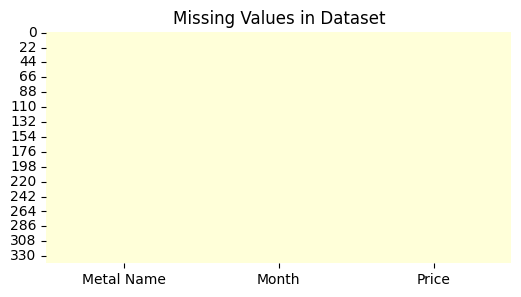

In [ ]:
# Missing Value Heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(df.isnull(), cbar=False, cmap='YlGnBu')
plt.title("Missing Values in Dataset")
plt.show()

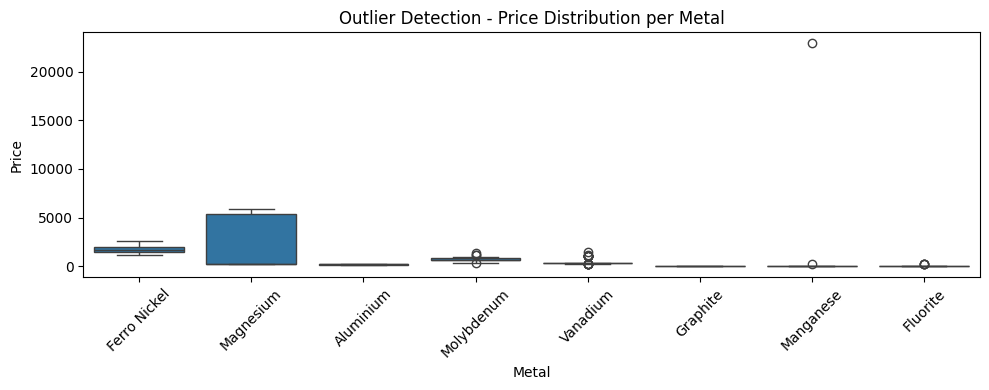

In [ ]:
# Boxplot to detect outliers per metal
plt.figure(figsize=(10, 4))
sns.boxplot(x='Metal Name', y='Price', data=df)
plt.xlabel("Metal")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.title("Outlier Detection - Price Distribution per Metal")
plt.tight_layout()
plt.show()


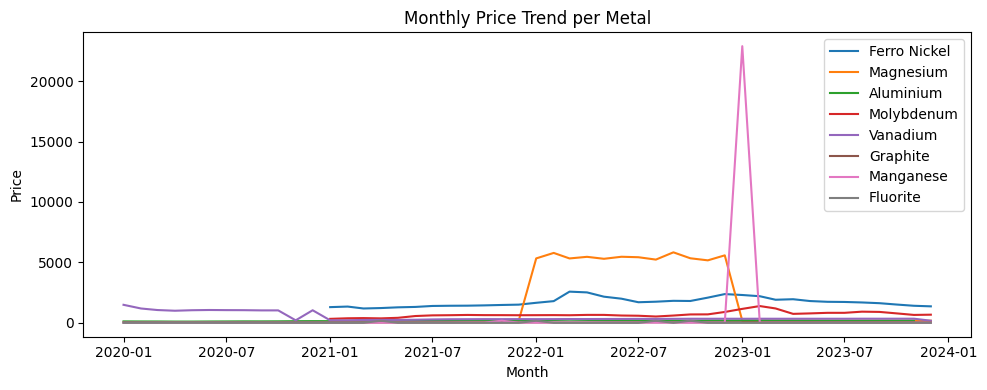

In [ ]:
#Line plots of price trends per metal
plt.figure(figsize=(10, 4))
for metal in df['Metal Name'].unique():
    subset = df[df['Metal Name'] == metal]
    plt.plot(subset['Month'], subset['Price'], label=metal)
plt.title("Monthly Price Trend per Metal")
plt.xlabel("Month")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


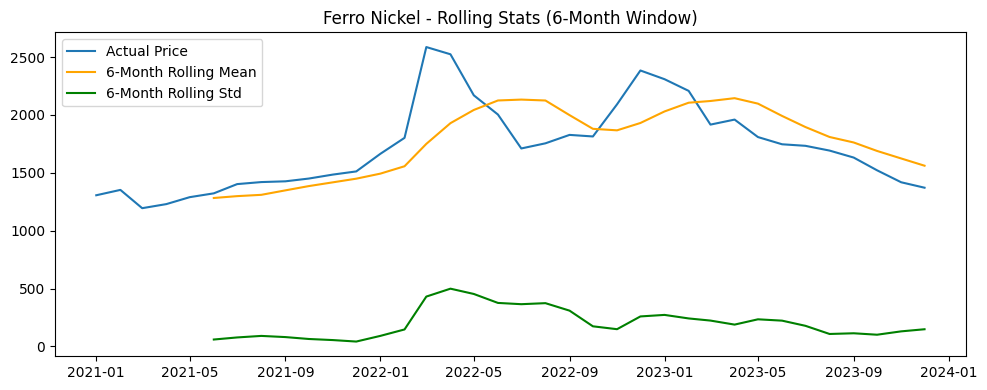

In [ ]:
# Rolling Mean & Std example (first metal)
example_metal = df['Metal Name'].unique()[0]
subset = df[df['Metal Name'] == example_metal].set_index('Month').sort_index()
rolling_mean = subset['Price'].rolling(window=6).mean()
rolling_std = subset['Price'].rolling(window=6).std()

plt.figure(figsize=(10, 4))
plt.plot(subset['Price'], label='Actual Price')
plt.plot(rolling_mean, label='6-Month Rolling Mean', color='orange')
plt.plot(rolling_std, label='6-Month Rolling Std', color='green')
plt.title(f"{example_metal} - Rolling Stats (6-Month Window)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

#Evaluation metrics function
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

In [ ]:
#Forecasting loop for each metal
metals = df['Metal Name'].unique()

for metal in metals:
    print(f"\nProcessing: {metal}")
    metal_df = df[df['Metal Name'] == metal][['Month', 'Price']].sort_values('Month')


Processing: Ferro Nickel

Processing: Magnesium

Processing: Aluminium

Processing: Molybdenum

Processing: Vanadium

Processing: Graphite

Processing: Manganese

Processing: Fluorite


In [ ]:
 # ✂ Remove outliers
clean_df = remove_outliers_iqr(metal_df)

In [ ]:
#Prophet model
prophet_df = clean_df.rename(columns={'Month': 'ds', 'Price': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast_prophet = prophet_model.predict(future)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpztg677cw/m8lsyety.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpztg677cw/xjifq73s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96301', 'data', 'file=/tmp/tmpztg677cw/m8lsyety.json', 'init=/tmp/tmpztg677cw/xjifq73s.json', 'output', 'file=/tmp/tmpztg677cw/prophet_model3d4esn05/prophet_model-20250812180243.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:02:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages

In [ ]:
 #SARIMA model
sarima_train = clean_df.set_index('Month')['Price']
try:
    sarima_model = SARIMAX(sarima_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_result = sarima_model.fit(disp=False)
    sarima_forecast = sarima_result.forecast(steps=12)
except:
    sarima_forecast = None


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  retu

In [ ]:
 #Evaluation for models (if enough data)
if len(clean_df) >= 24:
      train = clean_df[:-12]
      test = clean_df[-12:]



In [ ]:
# Prophet prediction
prophet_train = train.rename(columns={'Month': 'ds', 'Price': 'y'})
prophet_test = test.rename(columns={'Month': 'ds', 'Price': 'y'})
model = Prophet()
model.fit(prophet_train)
future_test = model.make_future_dataframe(periods=12, freq='M')
forecast_test = model.predict(future_test)
forecast_y = forecast_test[['ds', 'yhat']].tail(12)['yhat'].values
mae_p, rmse_p, mape_p = evaluate_model(prophet_test['y'].values, forecast_y)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpztg677cw/o0889_x9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpztg677cw/m_0riro8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19589', 'data', 'file=/tmp/tmpztg677cw/o0889_x9.json', 'init=/tmp/tmpztg677cw/m_0riro8.json', 'output', 'file=/tmp/tmpztg677cw/prophet_modelnu156n3u/prophet_model-20250812180245.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:

In [ ]:
 # SARIMA prediction
try:
    sarima_model_eval = SARIMAX(train.set_index('Month')['Price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_result_eval = sarima_model_eval.fit(disp=False)
    sarima_y = sarima_result_eval.forecast(steps=12)
    mae_s, rmse_s, mape_s = evaluate_model(test['Price'].values, sarima_y.values)
except:
      mae_s, rmse_s, mape_s = np.inf, np.inf, np.inf

print(f" Prophet MAE: {mae_p:.2f}, RMSE: {rmse_p:.2f}, MAPE: {mape_p:.2f}%")
print(f"SARIMA MAE: {mae_s:.2f}, RMSE: {rmse_s:.2f}, MAPE: {mape_s:.2f}%")

if rmse_p < rmse_s:
      print("Best Model: Prophet")
else:
      print("Best Model: SARIMA")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 Prophet MAE: 7.53, RMSE: 9.78, MAPE: 150.03%
SARIMA MAE: 1.16, RMSE: 1.48, MAPE: 21.45%
Best Model: SARIMA


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


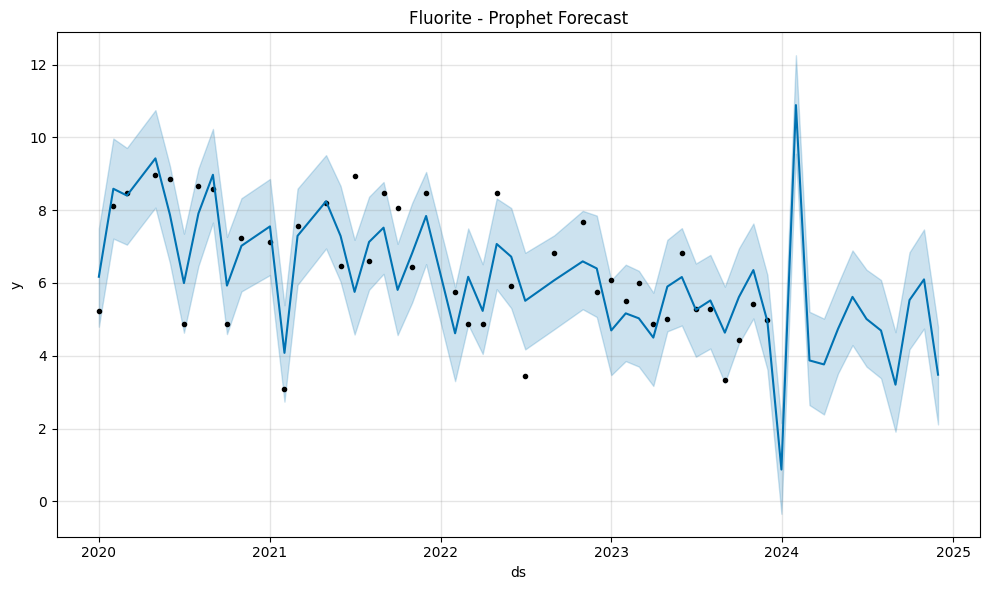

In [ ]:
# Plot Prophet forecast
prophet_model.plot(forecast_prophet)
plt.title(f"{metal} - Prophet Forecast")
plt.tight_layout()
plt.show()


/tmp/ipython-input-3472618012.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sarima_forecast.index = pd.date_range(sarima_train.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


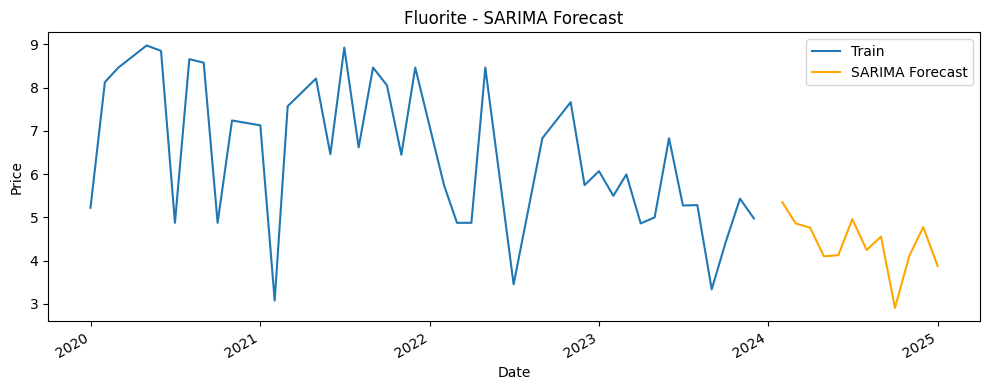

In [ ]:
# Plot SARIMA forecast if available
if sarima_forecast is not None:
        plt.figure(figsize=(10, 4))
        sarima_train.plot(label='Train')
        sarima_forecast.index = pd.date_range(sarima_train.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
        sarima_forecast.plot(label='SARIMA Forecast', color='orange')
        plt.title(f"{metal} - SARIMA Forecast")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.tight_layout()
        plt.show()
